In [1]:
!pip install torch torchvision torchaudio scikit-learn opencv-python

You should consider upgrading via the '/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/bin/python3 -m pip install --upgrade pip' command.


Using MPS device.
Using mps device
UNet(
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.5, inplace=False)
  (conv1): Double_Conv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv2): Double_Conv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv3): Double_Conv(
    (double_conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv4): Double_Conv(
    (double_conv): Sequential(
      (0): Conv2d

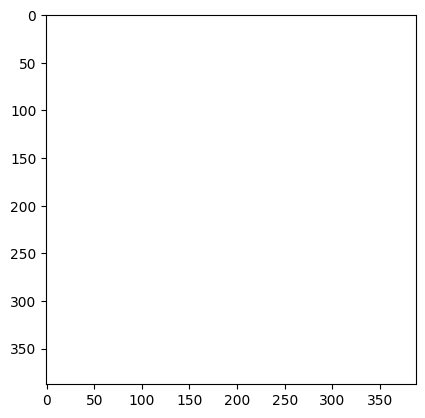

In [9]:
"""
Created on Aug 04 2025

@author: vigo
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import numpy as np 
import cv2 as cv

import re
import glob

from unet import UNet

torch.cuda.empty_cache()

NET_INPUT_SIZE = (572, 572)
NET_OUTPUT_SIZE = (388, 388)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        # Flatten the tensors
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (predictions * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        return 1 - dice_coeff


def Normalize(img):
    return np.array(img/255.0, dtype=np.float32)

def Shape_Process(img):
    if img.shape > NET_INPUT_SIZE:
        img = cv.resize(img, NET_INPUT_SIZE, interpolation = cv.INTER_CUBIC)   # image reduction
        
    elif img.shape < NET_INPUT_SIZE:
        if img.shape[0] % 2:
            img = cv.resize(img, img.shape[0] // 2, interpolation = cv.INTER_CUBIC)
        padd = int((NET_INPUT_SIZE[0] - img.shape[0]) / 2)
        img = cv.copyMakeBorder(img, padd, padd, padd, padd, cv.BORDER_REFLECT_101)
        
    return img

def Center_Crop(img):
    img = Shape_Process(img)
    crop_yx = (int((img.shape[0] - NET_OUTPUT_SIZE[0]) / 2), int((img.shape[1] - NET_OUTPUT_SIZE[1]) / 2))
    img = img[crop_yx[0]: crop_yx[0] + NET_OUTPUT_SIZE[0], crop_yx[1]: crop_yx[1] + NET_OUTPUT_SIZE[1]]
    
    return img

def Numerical_Sort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def Read_Images_Test(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
    
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis, np.newaxis]    # format => [N, H, W, C1, C2]
    return images

def Read_Images_Train(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
    
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis]    # format => [N, H, W, C]
    return images

def Read_Images_GTruth(folder_path, image_names):
    labels = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        mask = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        mask = Center_Crop(mask)
        mask = Normalize(mask)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        labels.append(mask)
    
    labels = np.asarray(labels, dtype=np.float32)
    labels = labels[:, :, :, np.newaxis]    # format => [N, H, W, C]
    return labels

def Matplotlib_Imshow(img):
    npimg = img.cpu().detach().numpy()
    npimg = (npimg * 255.0).astype("int")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

#%% dataset load and preprocessing

drive_path = "./data" 

test_images_path = drive_path + "/test/*.tif"

train_gtruth_path = drive_path + "/train/labels/*.tif"
train_images_path = drive_path + "/train/images/*.tif"

test_images = []
image_names = []
train_gtruth = []
train_images = []
test_images = Read_Images_Test(test_images_path, image_names)
train_images = Read_Images_Train(train_images_path, image_names)    
train_gtruth = Read_Images_GTruth(train_gtruth_path, image_names)

#%% Create data loaders.

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU instead.")

print(f'Using {device} device')
diceLoss = DiceLoss().to(device)

# pytorch input format => [N, H, W, C1] -> [N, C1, H, W]
train_tensor = torch.from_numpy(train_images).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
train_gtruth_tensor = torch.from_numpy(train_gtruth).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
# pytorch input format => [N, H, W, C1, C2] -> [N, C1, C2, H, W]
test_tensor = torch.from_numpy(test_images).transpose_(1 , 3).transpose_(2 , 4).float().to(device)

batch_size = 2
train_dl = DataLoader(train_tensor, batch_size=batch_size, shuffle=False)
train_gtruth_dl = DataLoader(train_gtruth_tensor, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_tensor, batch_size = len(test_images), shuffle=False)
test_iter = next(iter(test_dl))

#%% create model
model = UNet().to(device)
print(model)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 5

#%% train
for e in range(n_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    # Iterate through both DataLoaders together
    for batch_idx, (train_batch, gtruth_batch) in enumerate(zip(train_dl, train_gtruth_dl)):

        optim.zero_grad()
        
        prediction = model(train_batch)
        loss = diceLoss(prediction, gtruth_batch) 
        
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{e+1}/{n_epochs}], Average Loss: {avg_loss:.6f}')

print('Finished Training')

#%% predict 
test_img_index = 0
test_prediction = model(test_iter[test_img_index])   

# show images
img_grid = make_grid(test_prediction)
Matplotlib_Imshow(img_grid)

#%% model save
torch.save(model.state_dict(), "./model.pth")
print("Saved PyTorch Model State to model.pth")

#%% model load
model_test = UNet().to(device)
model_test.load_state_dict(torch.load("./model.pth"))

test_prediction = model_test(test_iter[0])
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

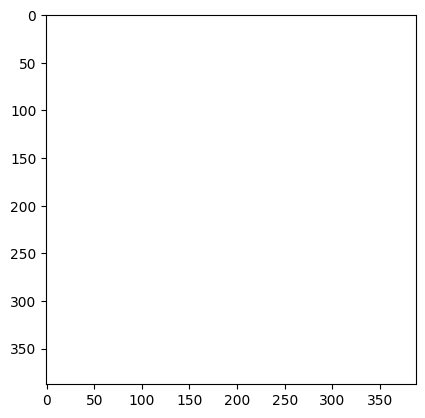

In [11]:
test_prediction = model_test(test_iter[7])
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

In [ ]:
print(loss.item())

In [ ]:
#%% Calculate metrics after training
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate on a few training samples
model.eval()
all_jaccard = []
all_f1 = []
all_recall = []
all_precision = []
all_accuracy = []

with torch.no_grad():
   for i in range(10):  # Test on 10 training samples
       # Get prediction
       img = train_tensor[i:i+1]
       gt = train_gtruth_tensor[i:i+1]
       pred = torch.sigmoid(model(img))
       
       # Convert to numpy and flatten
       pred_np = (pred.cpu().numpy().flatten() > 0.5).astype(int)
       gt_np = gt.cpu().numpy().flatten().astype(int)
       
       # Calculate metrics
       accuracy = accuracy_score(gt_np, pred_np)
       precision = precision_score(gt_np, pred_np, zero_division=0)
       recall = recall_score(gt_np, pred_np, zero_division=0)
       f1 = f1_score(gt_np, pred_np, zero_division=0)
       
       # Jaccard (IoU)
       intersection = np.sum(pred_np * gt_np)
       union = np.sum(pred_np) + np.sum(gt_np) - intersection
       jaccard = intersection / union if union > 0 else 0
       
       all_jaccard.append(jaccard)
       all_f1.append(f1)
       all_recall.append(recall)
       all_precision.append(precision)
       all_accuracy.append(accuracy)

# Average results
avg_jaccard = np.mean(all_jaccard)
avg_f1 = np.mean(all_f1)
avg_recall = np.mean(all_recall)
avg_precision = np.mean(all_precision)
avg_accuracy = np.mean(all_accuracy)

# Print table
print(f"Jaccard:   {avg_jaccard:.4f}")
print(f"F1 Score:  {avg_f1:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Accuracy:  {avg_accuracy:.4f}")